<a href="https://colab.research.google.com/github/georgezoto/TensorFlow-in-Practice/blob/master/C4W2_2_Time_series_trend_seasonality_noise_Dense_mse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc3


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

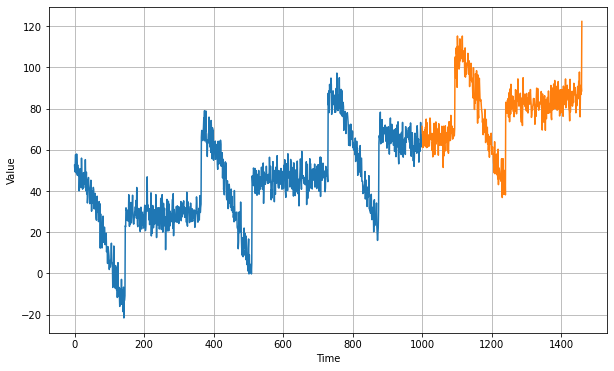

In [0]:
plt.figure(figsize=(10, 6))

plot_series(time_train, x_train)
plot_series(time_valid, x_valid)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), metrics=['accuracy'])
model.fit(dataset,epochs=50,verbose=1)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/50
31/31 [==============================] - 0s 2ms/step - loss: 461.8558 - accuracy: 0.0000e+00
Epoch 2/50
31/31 [==============================] - 0s 2ms/step - loss: 190.0158 - accuracy: 0.0000e+00
Epoch 3/50
31/31 [==============================] - 0s 2ms/step - loss: 163.8108 - accuracy: 0.0000e+00
Epoch 4/50
31/31 [==============================] - 0s 2ms/step - loss: 148.0193 - accuracy: 0.0000e+00
Epoch 5/50
31/31 [==============================] - 0s 2ms/step - loss: 138.5659 - accuracy: 0.0000e+00
Epoch 6/50
31/31 [==============================] - 0s 2ms/step - loss: 129.5074 - accuracy: 0.0000e+00
Epoch 7/50
31/31 [==============================] - 0s 2ms/step - loss: 122.8655 - accuracy: 0.0000e+00
Epoch 8/50
31/31 [==============================] - 0s 2ms/step - loss: 117.6461 - accuracy: 0.0000e+00
Epoch 9/50
31/31 [==============================] - 0s 2ms/step - loss: 110.5422 - ac

In [0]:
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.04292529],
       [-0.06003034],
       [-0.12568147],
       [ 0.12413348],
       [ 0.13928801],
       [-0.04836606],
       [-0.05267965],
       [ 0.05041023],
       [-0.05249092],
       [-0.17136675],
       [-0.03027576],
       [ 0.01343512],
       [ 0.09165959],
       [ 0.08489882],
       [ 0.13626154],
       [ 0.08202708],
       [-0.00438521],
       [ 0.12374628],
       [ 0.29035616],
       [ 0.34197554]], dtype=float32), array([0.01085013], dtype=float32)]


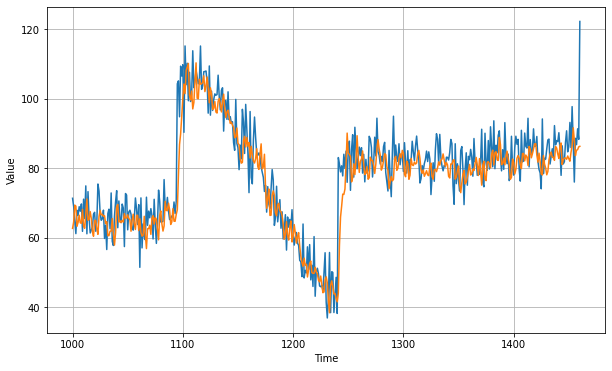

In [0]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.2385697